# Explainer Notebook of project in network analysis of articles

## 1. Motivation

### Dataset
For our project we analyze a huge dataset on articles and blog posts. We are interested in seing how these articles link to each other and whether there's a difference between positive and negative sentiment. Furthermore, we are curious about exploring the large communities of articles.

The dataset we analyze as a part of our project is the Stanford meme tracker dataset available publicly at: https://snap.stanford.edu/data/memetracker9.html. It includes data on memes (articles and blog posts) from August 2008 to April 2009. For most memes there is data on their (i) link, (ii) title, (iii) key phrases, (iv) links to other memes and (v) timestamp. The dataset contains 96 million memes with 418 million links. 

The sheer size of the dataset makes it interesting to analyze but also requires good data preprocessing and focus on specific topics. We still decided to stick with it, as the dataset structure allows for a simple creation of a network structure through the link attribute. Furthermore, the dataset is based on articles/blog posts from 2008/2009 which allows us to analyze data on the US presidential elections (Obama vs McCain).

### Goal for the end user's experience
We want to provide some value for the user by giving insights on how different sentiment affects the linking between articles. Furthermore, we want to create interesting insights about the Us presidential elections. The challenge here is to not overload our website with information, given the endless analysis possibilities with such a large dataset.

## 2. Basic dataset statistics and cleaning

### Dataset
The dataset is 13.3 GB large and contains 96 million memes with 418 million links. Therefore, significant data cleaning is required before reaching reasonable processing time for NLP or graphs computations. The density of the network is approximately zero, given that most memes are not linked to another meme. The degree distribution follows the powerlaw distribution seen below.

<div style="width:70%">
    <img src="./Degree_distribution.png">
</div>

### Data cleaning

The data contained several memes which are not that interesting for our purpose or not interesting enough to justify the increase in processing time. Therefore, any meme that fulfilled either of the following conditions was removed (brackets indicate approximate percentage removed):

- more than 40 outgoing links (~1%)
- no text (nor title or key phrase) (~34%)
- no incoming or outgoing links (~58%)
- less than a sum of 8 words in key phrases and title (~2%)

Furthermore, links were removed if:
- link to a meme that is not in the dataset (12% of links)

Based on these criteria, we managed to drastically reduce the size of our dataset. More importantly we also removed a lot of memes that were not of interest and may have distorted our analysis.

The cleaned new subdatset has an average node degree of 1.99 an there are baout as many nodes as there are edges. The density is increadibly low which makes sense since our network is not very well connected. The power law degree distribution is retained. This makes sense with regards to the nature of our network, where one can expect some articles to be very popular and big news stories that have many links to it, and most other articles only have few links to it if any, since they might just be sub stories of a larger news story.

The code used for the data preprocessing is the following:

##### Functions to clean the dataset

In [2]:
import gzip
import pickle
import matplotlib.pyplot as plt

#function to load the dataset
def load_and_unzip_txt_gz(file_path):
    filename ="subset.txt.gz"
    with gzip.open(file_path, 'rt', errors='ignore') as file:
        content = [line.strip() for line in file]
    return content

#functions to do the Data Cleaning
# Count number of objects and links in the data
def count_objects_and_links(data):
    object_count = 0
    link_count = 0
    for element in data:
        if element.startswith('P'):
            object_count += 1
        elif element.startswith('L'):
            link_count += 1
    return object_count, link_count

#remove lines with more than n=40 links or without any text (Q):
def remove_objects_with_conditions(data):
    new_data = []
    i = 0
    removed_link_count = 0
    removed_no_q_count = 0

    while i < len(data):
        if data[i].startswith('P'):
            link_count = 0
            has_q = False
            j = i + 1
            while j < len(data) and not data[j].startswith('P'):
                if data[j].startswith('L'):
                    link_count += 1
                elif data[j].startswith('Q'):
                    has_q = True
                j += 1
            
            if link_count > 50:
                removed_link_count += 1
            elif not has_q:
                removed_no_q_count += 1
            else:
                new_data.extend(data[i:j])

            i = j
        else:
            i += 1

    return removed_link_count, removed_no_q_count, new_data

#remove links to pages which are not present as P
def remove_links_to_nonexistent_objects(data):
    new_data = []
    object_links = {line.split("\t")[1] for line in data if line.startswith("P")}
    n_removed_objects = 0

    i = 0
    while i < len(data):
        if data[i].startswith('P'):
            new_data.append(data[i])
            j = i + 1
            while j < len(data) and not data[j].startswith('P'):
                if data[j].startswith('L'):
                    link = data[j].split("\t")[1]
                    if link in object_links:
                        new_data.append(data[j])
                    else:
                        n_removed_objects += 1
                else:
                    new_data.append(data[j])
                j += 1
            i = j
        else:
            i += 1

    print(f"Number of removed links to pages outside of the dataset: {n_removed_objects}")
    return new_data

#remove objects without incoming or outgoing link
def remove_nolink_objects(data):
    linked_objects = set()

    for line in data:
        if line.startswith("L"):
            _, link = line.split("\t", 1)
            linked_objects.add(link)

    new_data = []
    current_object = []
    removed_objects_count = 0

    for line in data:
        if line.startswith("P"):
            if current_object:
                if current_object[0].split("\t", 1)[1] in linked_objects:
                    new_data.extend(current_object)
                else:
                    removed_objects_count += 1
            current_object = []
        current_object.append(line)

    if current_object:
        if current_object[0].split("\t", 1)[1] in linked_objects:
            new_data.extend(current_object)
        else:
            removed_objects_count += 1

    print(f"Removed objects without incoming or outgoing link: {removed_objects_count}")
    return new_data


def data_cleaning(data):
    object_count, link_count = count_objects_and_links(data)
    print(f"Number of objects in the list: {object_count}")
    print(f"Total number of links in the list: {link_count}")
    removed_link_count, removed_no_q_count, filtered_data = remove_objects_with_conditions(data)
    print(f"Removed objects with more than 40 links: {removed_link_count}")
    print(f"Removed objects with no 'Q': {removed_no_q_count}")
    filtered_data = remove_links_to_nonexistent_objects(filtered_data)
    filtered_data = remove_nolink_objects(filtered_data)
    return filtered_data

##### Loading and cleaning the dataset

In [ ]:
# Define a list of filenames
filenames = ['quotes_2008-08.txt.gz', 'quotes_2008-09.txt.gz', 'quotes_2008-10.txt.gz', 'quotes_2008-11.txt.gz', 'quotes_2008-12.txt.gz', 'quotes_2009-01.txt.gz', 'quotes_2009-02.txt.gz', 'quotes_2009-03.txt.gz']

# Define an empty list to store the results
content = []

# Loop through the filenames and process each file
for filename in filenames:
    print(filename)
    result = load_and_unzip_txt_gz(filename)
    # Append the result to the list of results
    result = data_cleaning(result)
    content.append(result)

##### Save and reload cleaned dataset

In [ ]:
#flatten the list
content = [item for sublist in content for item in sublist]

# Save the list to a file
with open('content_full.pickle', 'wb') as f:
    pickle.dump(content, f)
    
# Load the list from the file
with open('content_full.pickle', 'rb') as f:
    content = pickle.load(f)
    
# Count number of objects and links in the data
count_objects_and_links(content)

##### Another filtering step added (less than 8 words):

In [ ]:
def filter_q_wordcount(data_list):
    current_object = {"P": "", "T": "", "Q": [], "L": ""}
    object_lines = []
    for line in data_list:
        if line.startswith('P'):
            # If we already have a current object and it has 8 or more words in its Q attributes, add it to the list
            if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) >= 8:
                object_lines.append(f'P\t{current_object["P"]}')
                if current_object["T"]:
                    object_lines.append(f'T\t{current_object["T"]}')
                for q in current_object["Q"]:
                    object_lines.append(f'Q\t{q}')
                if current_object["L"]:
                    object_lines.append(f'L\t{current_object["L"]}')
            # start a new object
            current_object = {"P": line[2:], "T": "", "Q": [], "L": ""}
        elif line.startswith('T'):
            current_object["T"] = line[2:]
        elif line.startswith('Q'):
            current_object["Q"].append(line[2:])
        elif line.startswith('L'):
            current_object["L"] = line[2:]

    # Don't forget the last object
    if current_object["P"] and sum(len(q.split()) for q in current_object["Q"]) >= 8:
        object_lines.append(f'P\t{current_object["P"]}')
        if current_object["T"]:
            object_lines.append(f'T\t{current_object["T"]}')
        for q in current_object["Q"]:
            object_lines.append(f'Q\t{q}')
        if current_object["L"]:
            object_lines.append(f'L\t{current_object["L"]}')
    
    return object_lines

count_objects_and_links(content)
content = filter_q_wordcount(content)
count_objects_and_links(content)

## 2.1 Create the network

Load the preprossed article data

In [4]:
import pickle

with open('data/preprossed_data.pickle', 'rb') as file:
    content = pickle.load(file)

Create the network, where the links of the articles are used to create a directed graph. The directed edge represents a link from on aritcle to another. The sentiment of each article is also computed as the sum of all the article words' nlth sentiment (cleaned for stop words) divided by the log count of all the words in the article. It is more fair to divide by the log count, since longer articles with sentiment would get a negligable average compared to articles that only have one or two key phrases with sentiment and nothing else.

In [ ]:
import networkx as nx
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from math import log
import time


nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_and_get_sentiment_score(phrase):
    tokens = nltk.word_tokenize(phrase)
    non_stopwords = [word for word in tokens if word.lower() not in stop_words]
    non_stopword_count = len(non_stopwords)
    filtered_phrase = ' '.join(non_stopwords)
    sentiment_score = TextBlob(filtered_phrase).sentiment.polarity
    return sentiment_score, non_stopword_count

start = time.time()

# Initialize an empty graph
G = nx.DiGraph()

current_node = None
counter=0

sentiment_scores = defaultdict(float)
non_stopword_counts = defaultdict(int)

content = content
n_lines = len(content)
for line in content:
    counter += 1
     
    parts = line.split("\t")
    
    if parts[0] == "P":
        current_node = parts[1].strip()
        G.add_node(current_node, name=current_node, key_phrases=[], links=[])
    elif current_node is not None:
        if parts[0] == "T":
            G.nodes[current_node]["timestamp"] = parts[1].strip()
        elif parts[0] == "Q":
            phrase = parts[1].strip()
            G.nodes[current_node]["key_phrases"].append(phrase)
            sentiment_score, non_stopword_count = preprocess_and_get_sentiment_score(phrase)
            sentiment_scores[current_node] += sentiment_score
            non_stopword_counts[current_node] += non_stopword_count
        elif parts[0] == "L":
            link = parts[1].strip()
            if not G.has_node(link):
                G.add_node(link, name=link, key_phrases=[], links=[])
            G.add_edge(current_node, link)
    
    if counter % 10**4 == 0:
        print(f"{counter/n_lines} in {(time.time() - start)/60} minuts")
        
for node in G.nodes:
    non_stopword_count = non_stopword_counts[node]
    if non_stopword_count not in [0,1]:
        log_non_stopword_count = log(non_stopword_count)
        normalized_sentiment_score = sentiment_scores[node] / log_non_stopword_count
    else:
        normalized_sentiment_score = sentiment_scores[node]
    G.nodes[node]["normalized_sentiment_score"] = normalized_sentiment_score
    if normalized_sentiment_score < -0.4:
        G.nodes[node]["sentiment_color_group"] = 0
    elif -0.4 <= normalized_sentiment_score < -0.2:
        G.nodes[node]["sentiment_color_group"] = 1
    elif -0.2 <= normalized_sentiment_score < -0.05:
        G.nodes[node]["sentiment_color_group"] = 2
    elif -0.05 <= normalized_sentiment_score < 0.05:
        G.nodes[node]["sentiment_color_group"] = 3
    elif 0.05 <= normalized_sentiment_score < 0.2:
        G.nodes[node]["sentiment_color_group"] = 4
    elif 0.2 <= normalized_sentiment_score < 0.4:
        G.nodes[node]["sentiment_color_group"] = 5
    elif 0.4 <= normalized_sentiment_score:
        G.nodes[node]["sentiment_color_group"] = 6
    
        
stop = time.time()
print(f"time taken to process: {(stop - start)/60} minuts")

# Now G contains the network created from the list
#save for later use
pickle.dump(G, open('data/G_sentiment.pickle', 'wb'))
G_full_backup = G

## 2.2 Extract the 100 largest connected components

We extarct the 100 largest connected components to continue working on since our dataset is huge and we have many very small components in our network.

In [ ]:
# Compute the weakly connected components in the graph
weakly_connected_components = list(nx.weakly_connected_components(G))

# Sort the components by size in descending order
sorted_weakly_connected_components = sorted(weakly_connected_components, key=len, reverse=True)

# Select the 100 largest components
hundred_largest_weakly_connected_components = sorted_weakly_connected_components[:100]

# Create subgraphs for each of the 100 largest components
hundred_largest_weakly_connected_subgraphs = [G.subgraph(component) for component in hundred_largest_weakly_connected_components]


In [ ]:
#Create new graph that is the subgraph containing the top 100 largest connected components
new_graph_top_connected = nx.DiGraph()
for subgraph in hundred_largest_weakly_connected_subgraphs:
    new_graph_top_connected = nx.compose(new_graph_top_connected, subgraph)
G = new_graph_top_connected


# 3. Tools, theory and analysis. Describe the process of theory to insight
### Talk about how you've worked with text, including regular expressions, unicode, etc. 
First we removed stopwords from all the keyphrases. We computed the log normalised sentiment score for each article by summing the nltk sentiment score of each word in the key phrases and dividing by the log length of the all the articles key phrases. We used the log normalised score insted of the normalised score because we did not want articles with just one or two key phrases to have overly high or low scores just because they where short and therefore could achieve a level of normalised sentiment that the longer articles would never be able to. This gave of a measure of the overall sentiment of an article, which we added as a node attribute to each article.

We also used wordcloud to explore the topics of different network clusters.


### Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

We worked with assortativity wrt. to sentiment. Assortativity wrt. to an attribute (for example sentiment) measures if the nodes in the network are more or less likely to be connected to nodes with the same level of that measure than they would be by random. a value of 0 is neutral and above means that the nodes are more likely bind to the same measure than they would be by random, and a score below 0 means that they are less liekly than they would be by random. We did this because we wanted to investigate if positive articles where biased in linking to other positive articvles and vica versa for negative articles.

We also used modularity to find communities. Modularity quantifies the quality of community structures. It does so by comparing the number of edges within communities to the expected number in a random graph. It thereby finds the presence of densely connected groups whrere the nodes have more connections within their group then outside.


### How did you use the tools to understand your dataset?
The positive assortivity ceofficient with respect to sentiment gave us a good understanding of how the sentiment of an article impacts which other articles it is more likely to link to.

In our network of articles, modularity is used to extract communities because it allows us to identify clusters of articles that are highly interconnected, which can indicate that they share similar topics or themes, and we want to look at these themes to learn about the news of the period which our network of articles is written.

## 3.1 Sentiment analysis of the network consisting of the 100 largest connected components

In [ ]:
with open(f"top100network.pickle", "rb") as file:
    G=pickle.load(file)

Plot the netowrk and color the nodes (aritcles) based on sentiment

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw
import numpy as np

# Customize the network visualization styles

color_map= {
    0: "#b30000",  # Dark red (closer to light red)
    1: "#e60000",  # Red
    2: "#ff6a6a",  # Light red
    3: "#808080",  # Gray
    4: "#99ff99",  # Light green
    5: "#33cc33",  # Medium green
    6: "#1e8e1e"   # Dark green (closer to light green)
}

for node in G.nodes:
    G.nodes[node]["group"] = color_map[G.nodes[node]["sentiment_color_group"]]

dict_ = nx.get_node_attributes(G,'group')

# Draw the graph with node colors based on their sentiment scrore
dict_ = nx.get_node_attributes(G,'sentiment score')
nx.set_node_attributes(G,dict_,"group")
results = nw.visualize(G)

Compute summary statistics

In [ ]:
# Calculate summary statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
node_degree_dict = dict(G.degree())
avg_degree = sum(node_degree_dict.values()) / num_nodes
density = nx.density(G)

# Print summary statistics
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average degree: {avg_degree:.2f}")
print(f"Density: {density:.4f}")

# Calculate and print some additional statistics if the graph is not empty
if num_nodes > 0:
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    
    max_in_degree_node = max(in_degrees, key=in_degrees.get)
    max_out_degree_node = max(out_degrees, key=out_degrees.get)
    
    print(f"Node with maximum in-degree: {max_in_degree_node} (in-degree: {in_degrees[max_in_degree_node]})")
    print(f"Node with maximum out-degree: {max_out_degree_node} (out-degree: {out_degrees[max_out_degree_node]})")

    # Calculate connected components for a weakly connected version of the graph
    G_weak = nx.DiGraph.to_undirected(G)
    connected_components = [c for c in nx.connected_components(G_weak)]
    num_connected_components = len(connected_components)
    largest_connected_component = max(connected_components, key=len)
    
    print(f"Number of connected components: {num_connected_components}")
    print(f"Size of the largest connected component: {len(largest_connected_component)}")

Plot the sentiment distribution

In [ ]:
import matplotlib.pyplot as plt
# Collect sentiment scores from all nodes
sentiment_scores_list = [attributes["normalized_sentiment_score"] for _, attributes in G.nodes(data=True)]

# Plot the histogram of sentiment scores
plt.hist(sentiment_scores_list, bins=100, edgecolor='black')
plt.xlabel('Normalized Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores in the Network')
plt.show()

# Compute the assortativity coefficient based on sentiment scores
sentiment_assortativity = nx.attribute_assortativity_coefficient(G, "normalized_sentiment_score")
print(f"Assortativity coefficient based on sentiment scores: {sentiment_assortativity:.4f}")


# Explainer of the sentiment distribution and assortativity coefficient (see on website)

### Assortativity coefficient with respect to sentiment
We computed the log normalised sentiment for each article by summing the nltk sentiment score of each word in the key phrases and dividing by the log length of the key phrases. This gave of a measure of the overall sentiment of an article, which we used to compute the assortativity wrt. sentiment.
##### Sentiment Assortativity coefficient = 0.143
This coefficient confirms our hypothesis that positive articles are more likely to link to other positive articles whilst negative articles are more likely to link to other negative articles, then they would be expected to by random. The same goes for neutral articles.


### Sentiment distribution histogram
As the histogram shows we have many articles with an average neutral sentiment (sentiment = 0) and less so that are overall positively or negatively charged. Most are within the range of [-1,1] with a few outliers.

### Sentiment plot
The sentiment network plot has colored positive articles in green and negative ones in red based on their sentiment scores, whilst neutral was colored grey. The plot also shows how the clusters/groups of articles tends to share sentiment levels.

## 3.2 Extract communities for later NLP analysis by wordclouds

In [ ]:
import networkx as nx
import community
import netwulf as nw
import matplotlib.pyplot as plt# Text for website for the sentiment distribution and assortativity coef.

### Assortativity coefficient with respect to sentiment
We computed the log normalised sentiment for each article by summing the nltk sentiment score of each word in the key phrases and dividing by the log length of the key phrases. This gave of a measure of the overall sentiment of an article, which we used to compute the assortativity wrt. sentiment.
##### Sentiment Assortativity coefficient = 0.143
This coefficient confirms our hypothesis that positive articles are more likely to link to other positive articles whilst negative articles are more likely to link to other negative articles, then they would be expected to by random. The same goes for neutral articles.


### Sentiment distribution histogram
As the histogram shows we have many articles with an average neutral sentiment (sentiment = 0) and less so that are overall positively or negatively charged. Most are within the range of [-1,1] with a few outliers.


G = nx.DiGraph.to_undirected(G)
# Find communities using the Louvain algorithm
partition = community.best_partition(G)

# Compute the modularity of the partition
modularity = community.modularity(partition, G)

#Compute then number of communities
n_comm = len(set(partition.values()))

# Print the modularity value
print('The number of communities are:', str(n_comm))
print('The modularity is : ', modularity, " Whcih is significantly above 0")

#Create histogram showing community size distribution
count_dict = {}

# Loop over the values of the dictionary
for value in partition.values():
    if value in count_dict:
        count_dict[value] += 1
    else:
        count_dict[value] = 1
        
plt.hist(count_dict.values(), edgecolor='black')
plt.xlabel('Community size')
plt.ylabel('Occurrences of communities with given size')
plt.title('Histogram of community sizes')
plt.show

In [ ]:
# Identify the 10 largest communities
sorted_communities = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Create subgraphs for each of the 10 largest communities
subgraphs = []
for comm_id, _ in sorted_communities:
    nodes_in_community = [node for node, comm in partition.items() if comm == comm_id]
    subgraph = G.subgraph(nodes_in_community)
    subgraphs.append(subgraph)

# Save the subgraphs to files
for i, subgraph in enumerate(subgraphs, start=1):
    graph_to_pickle = nx.DiGraph(subgraph)
    with open(f"data/community{i}.pickle", "wb") as file:
        pickle.dump(graph_to_pickle, file)

In [ ]:
# Visualization using netwulf
nx.set_node_attributes(G,partition,"group")

#Write community assignment to txt for later use
with open('partition.txt', 'w') as file:
    for node, community in partition.items():
        file.write(str(node) + ',' + str(community) + '\n')

results = nw.visualize(G)

# Explainer of the community plot (see on website)

### Why filter the dataset to the 100 largest weakly connected components?
Even after the prepossessing which filtered away many of the nodes without text, we still had a network with millions of nodes. However, many of these nodes were isolated articles that were only connected to one or two other nodes which were otherwise isolated from the rest of the nodes. We expect these to be small articles about very specific topics, and we decided to focus on the nodes that where in more connected parts of the network, since we believed they would represent larger news stories about the more popular topics. We extract this subgraph because we want to use NLP to analyse the large clusters.

### Community plot
After performing that filtering, we still had a network with around 11.000 nodes and edges. We performed community detection within these connected subcomponents, and the result can be seen in the network, where each node is coloured by their community. It can be seen that there are tendencies for some nodes to be exclusively connected to the same one high degree node which we hypothesise can be a breaking news story which many other articles will reference two. We do not report the modularity since it does not make sense to analyse when we have filtered out all the isolated nodes.

## 3.3 Keyword article sentiment over time. Keyword example: Obama

In [ ]:
# Create a subgraph containing nodes with key phrases that contain "obama" or "Obama"
obama_nodes = [node for node, attrs in G.nodes(data=True) if any("obama" in phrase.lower() for phrase in attrs["key_phrases"])]
obama_subgraph = G.subgraph(obama_nodes)
graph_to_pickle = nx.DiGraph(obama_subgraph)

with open(f"data/Obama.pickle", "wb") as file:
    pickle.dump(graph_to_pickle, file)

In [ ]:
with open(f"top100network.pickle", "rb") as file:
    obama_graph = pickle.load(file)

In [ ]:
#create an obama gif
G = obama_graph

import matplotlib.pyplot as plt
import networkx as nx
import netwulf as nw
import numpy as np

# Customize the network visualization styles

color_map= {
    0: "#b30000",  # Dark red (closer to light red)
    1: "#e60000",  # Red
    2: "#ff6a6a",  # Light red
    3: "#808080",  # Gray
    4: "#99ff99",  # Light green
    5: "#33cc33",  # Medium green
    6: "#1e8e1e"   # Dark green (closer to light green)
}

for node in G.nodes:
    G.nodes[node]["group"] = color_map[G.nodes[node]["sentiment_color_group"]]

dict_ = nx.get_node_attributes(G,'group')

# Draw the graph with node colors based on their sentiment scrore
dict_ = nx.get_node_attributes(G,'sentiment score')
nx.set_node_attributes(G,dict_,"group")
results = nw.visualize(G)

In [ ]:
# Create a subgraph containing nodes with key phrases that contain "obama" or "Obama"
obama_nodes = [node for node, attrs in G.nodes(data=True) if any("obama" in phrase.lower() for phrase in attrs["key_phrases"])]
obama_subgraph = G.subgraph(obama_nodes)
graph_to_pickle = nx.DiGraph(obama_subgraph)

with open(f"data/Obama.pickle", "wb") as file:
    pickle.dump(graph_to_pickle, file)

This code is for manually creating all the monthly networks of the Obama network

In [ ]:
from datetime import datetime

G = obama_graph

# Set the cutoff date

#the graph of the different month was manually created by changing the konth and year and saving the image each time in netwulf
cutoff_date = datetime.strptime('2009-04-01', '%Y-%m-%d')

# Filter the nodes based on their 'timestamp' attribute
filtered_nodes = []
for node, attrs in G.nodes(data=True):
    try:
        if datetime.strptime(attrs['timestamp'], '%Y-%m-%d %H:%M:%S') < cutoff_date:
            filtered_nodes.append(node)
    except:
        pass

# Create a subgraph with the filtered nodes
subgraph_before_date = G.subgraph(filtered_nodes)
results = nw.visualize(subgraph_before_date)


The code blow is for making the linegraph gif of the obama average article sentiment for each month

In [ ]:
import imageio
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime

# Extract overall, average positive, and average negative sentiment per month
sentiments_by_month = defaultdict(list)
positive_sentiments_by_month = defaultdict(list)
negative_sentiments_by_month = defaultdict(list)

for node, attrs in G.nodes(data=True):
    try:
        timestamp = datetime.strptime(attrs['timestamp'], '%Y-%m-%d %H:%M:%S')
        month = datetime(timestamp.year, timestamp.month, 1)
        sentiment = attrs['normalized_sentiment_score']
    except:
        pass
    
    sentiments_by_month[month].append(sentiment)
    
    if sentiment > 0:
        positive_sentiments_by_month[month].append(sentiment)
    elif sentiment < 0:
        negative_sentiments_by_month[month].append(sentiment)

average_sentiments = {month: sum(sentiments) / len(sentiments) for month, sentiments in sentiments_by_month.items()}
average_positive_sentiments = {month: sum(sentiments) / len(sentiments) for month, sentiments in positive_sentiments_by_month.items()}
average_negative_sentiments = {month: sum(sentiments) / len(sentiments) for month, sentiments in negative_sentiments_by_month.items()}

# Create the GIF
with imageio.get_writer('visuals_for_website/obama_sentiment_over_time.gif', mode='I', duration=1) as writer:
    for i in range(len(average_sentiments)):
        fig, ax = plt.subplots(figsize=(10, 6))
        months_to_plot = sorted(average_sentiments)[: i + 1]
        
        # Plot overall average sentiment
        overall_avg_sentiments = [average_sentiments[month] for month in months_to_plot]
        ax.plot(months_to_plot, overall_avg_sentiments, label='Overall Articles Average', color='blue')
        
        # Plot average positive sentiment
        positive_avg_sentiments = [average_positive_sentiments.get(month, 0) for month in months_to_plot]
        ax.plot(months_to_plot, positive_avg_sentiments, label='Positive Articles Average', color='green')
        
        # Plot average negative sentiment
        negative_avg_sentiments = [average_negative_sentiments.get(month, 0) for month in months_to_plot]
        ax.plot(months_to_plot, negative_avg_sentiments, label='Negative Articles Average', color='red')
        
        ax.set(xlabel='Month', ylabel='Average Sentiment',
               title='Average Sentiment Over Time')
        ax.legend(loc='lower left')
        ax.set_ylim(-0.25, 0.25)
        ax.set_xlim(min(average_sentiments), max(average_sentiments))
        
        # Save the current frame as a png file
        plt.savefig(f"visuals_for_website/sentiment_frame{i + 1}.png")
        
        # Add the png file to the gif
        image = imageio.imread(f"visuals_for_website/sentiment_frame{i + 1}.png")
        writer.append_data(image)
        
        # Close the plot to prevent memory issues
        plt.close()


# Explainer for the Obama gifs (see on website)

### Keyword filtering example: "Obama"
An interesting potential user feature of our tool is that one can filter the network for one or more keywords and only look at the network of articles that contain one or more of these and analyse that. We made an example with Obama, who was elected president on November 4th 2008, during the period in which our data is recorded. The visuals show how the network grows for each month, where the nodes are coloured by sentiment.


### Obama timeline sentiment
The line graph shows how the monthly averages sentiment scores of all the articles, the overall positive articles and the overall negative articles change during the period from August 2008 to March 2009. Obama widely known to have had a good closing month during October before the election on November 4th, which can also be seen on the graph. It is interesting to see how the negative articles are at their most negative just before the election in October and then again in February, just as the bear market was going down to its lowest level indicated by the Dow Jones index. It is also interesting that the positivity of the positive articles seems to go up during the same periods as if to counterattack the negativity.
https://www.google.com/finance/quote/.DJI:INDEXDJX?sa=X&ved=2ahUKEwjgve3cuNn-AhXTi_0HHWLCDv0Q3ecFegQIHRAg


## 3.4 Wordclouds

# NLP analysis for Website

This script generates word clouds for articles related to (i) Obama, (ii) McCain, (iii) the n=10 largest communities in our article network. 

The following should be included on our website:

**How did the rhetorics of news articles around Obama and McCain differ?**

Going further than the sentiment of the articles, we also analyzed the words used in articles related to Obama and his republican counterpart John McCain. The words most often used in their context are visualized in two word clouds. Blue for the Obama and red for McCain. A striking difference between the two, is how often Obama was used in articles with McCain, whereas the name McCain did not appear nearly as often in articles with Obama. This may likely be due to our analysis period. We analyze articles from 2008 to 2009. While both names are likely to be used in the same article before the election, the focus shifts to the winner right. By the end of 2008, after Obama was elected, McCain did not get nearly as much media attention anymore.

*** Show word cloud of Obama and McCain ***

**What are the large communities in our meme network?**

Our network is comprised of mostly unconnected nodes and small clusters. However, due to the sheer size of our network, we still found some large communities. The topics of these communities differ significantly. The US presidential election of 2008 is the main topic in four of the ten largest communities. Three word clouds of large communities in our network are shown below to give an overview of the topics. Our largest community is the "True crime community". It is composed of articles of shocking stories, often involving killing and other horrible stories happening around the world. It's the type of article that makes people believe that everything in our world is bad.  The second largest is the "US elections community". And finally the ninth largest community is dedicated to love-life. We shall refer to it as the "Heartbeats community". 


*** Show word clouds of communities 1,2 and 9***


## Obama article word cloud

['hot angry tears of betrayal', 'blah-dey blah blappity blah friedman obama love', 'it is time for voters to wake up to the fact that government cannot create jobs it can only shift jobs from one part of the economy to the other it is entrepreneurs who create jobs and it is consumers who judge whether those jobs are the best jobs to be created the government contributes best by establishing a rule of law and protection of property rights that allows entrepreneurs and consumers to act in their best interests', 'stepped in it', "americans are worried about their access to quality affordable health care and they are looking for responsible solutions republicans agree and we are committed to developing new and innovative solutions to fix what's broken while making sure that we keep what works", 'fake news controversy', 'caused an appearance of impropriety', "we're better at this than you people we have relationships where you often have none let's try to exercise the known and the knowable

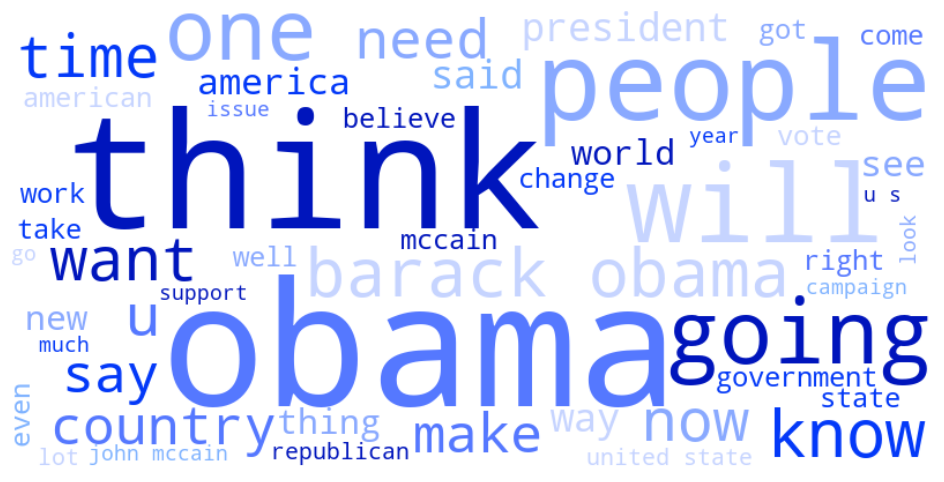

<Figure size 640x480 with 0 Axes>

In [2]:
# Import necessary packages
import pickle
import networkx as nx
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl

#load Obama graph
with open(f"obama_and_largest_conn_components/Obama.pickle", "rb") as file:
    G = pickle.load(file)
    
# Get all "key phrases" node attribute values
key_phrases_obama = nx.get_node_attributes(G, 'key_phrases').values()
key_phrases_obama = list(set([phrase for phrases in key_phrases_obama for phrase in phrases]))
print(key_phrases_obama[:10])

flattened_string_obama = ' '.join(key_phrases_obama)

colors = ['#0015bc', '#0339f8', '#5578ff', '#89a9ff', '#c6d4ff', '#80b3ff']
cmap = mcolors.ListedColormap(colors)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=STOPWORDS,
                      min_font_size=10, max_font_size=150, colormap= cmap).generate(flattened_string_obama)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("visuals_for_website/obama_wordcloud.png", dpi=400)

["i don't see any method at all sir", "one thing seems certain it isn't helping john mccain"]


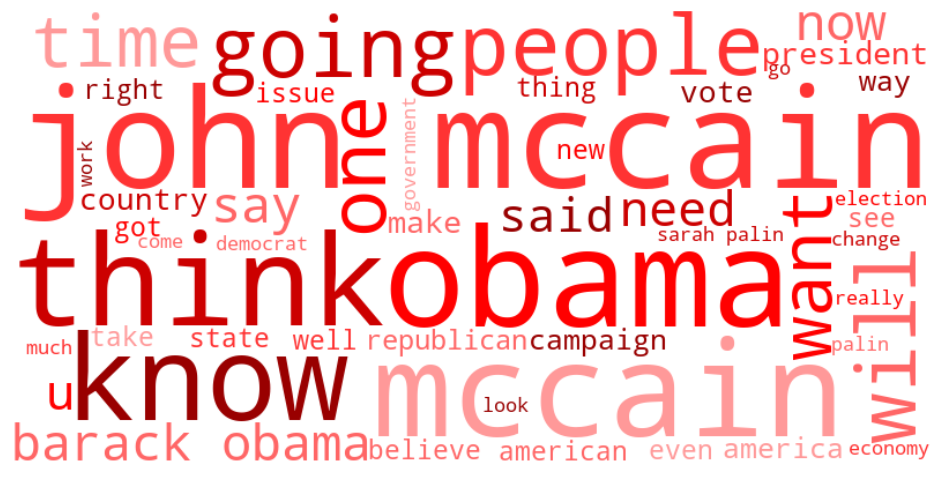

<Figure size 640x480 with 0 Axes>

In [3]:
with open('mccain_subgraph.pickle', 'rb') as file:
    G = pickle.load(file)
    
# Get all "key phrases" node attribute values
key_phrases_mccain = nx.get_node_attributes(G, 'key_phrases').values()
key_phrases_mccain = list(set([phrase.lower() for phrases in key_phrases_mccain for phrase in phrases]))
print(key_phrases_mccain[:2])

flattened_string_mccain = ' '.join(key_phrases_mccain)

# Import necessary packages
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl

colors = ['#ff0000', '#990000', '#cc0000', '#ff3333', '#ff6666', '#ff9999']
cmap = mcolors.ListedColormap(colors)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=STOPWORDS,
                      min_font_size=10, max_font_size=150, colormap= cmap).generate(flattened_string_mccain)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig("visuals_for_website/mccain_wordcloud.png", dpi=400)

## Word cloud of largest communities

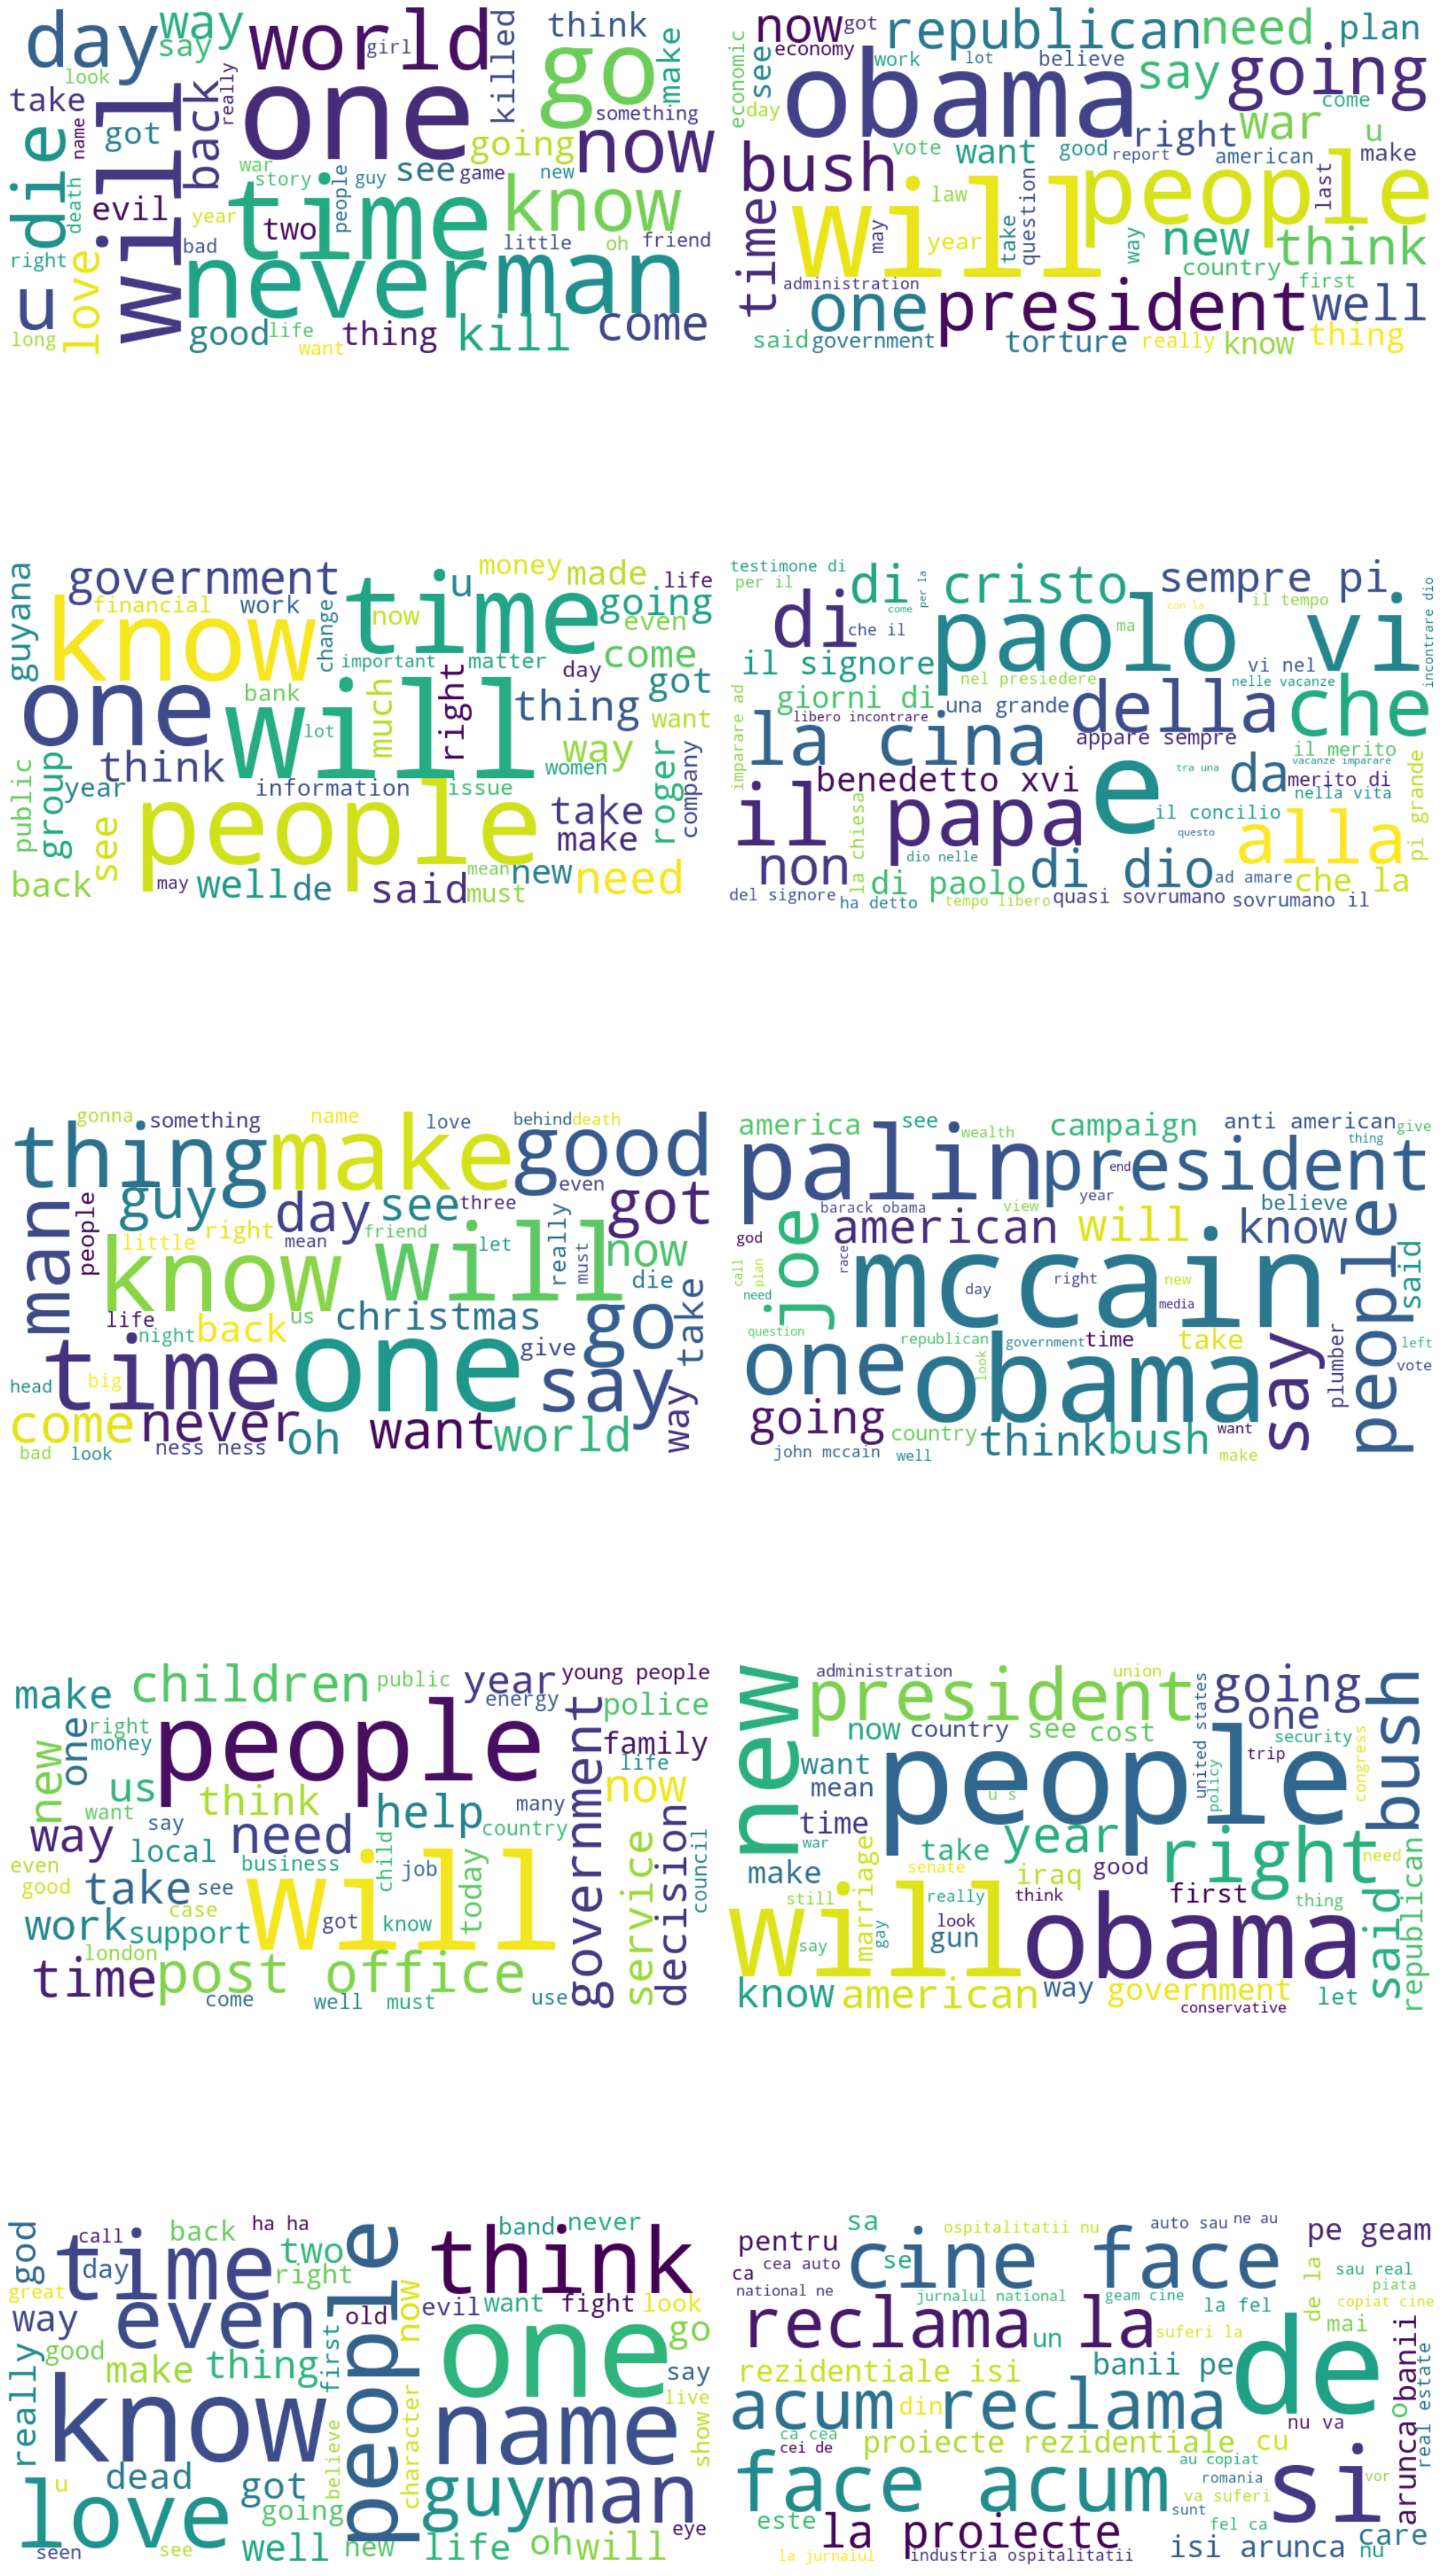

In [4]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to load a network from a pickle file
def load_network_from_pickle(filename):
    with open(filename, "rb") as file:
        network = pickle.load(file)
    return network

# Create a function to generate word clouds
def generate_wordcloud(subgraph, index):
    key_phrases = [node_attr['key_phrases'] for _, node_attr in subgraph.nodes(data=True)]
    key_phrases_flat = [phrase for phrases in key_phrases for phrase in phrases]
    flattened_string = ' '.join(key_phrases_flat)

    wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white',
                          min_font_size=10, max_font_size=150).generate(flattened_string)

    plt.subplot(5, 2, index + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.title(f"Word Cloud for Community {index + 1}")
    plt.savefig(f"visuals_for_website/community{i}_wordcloud.png", dpi=400)

# Load networks from pickle files and generate word clouds
plt.figure(figsize=(20, 40))
for i in range(1, 11):
    filename = f"obama_and_largest_conn_components/community{i}.pickle"
    G = load_network_from_pickle(filename)
    generate_wordcloud(G, i - 1)

plt.tight_layout()
plt.show()

 # 4. Discussion
Our project aimed to analyze a network of articles from 2008/2009 to understand the connections between them by their links. We successfully created a graph representation of the article connections and extracted valuable insights on the assortativity with respect to sentiment and the communities within the network. The project benefited from the use of network analysis and natural language processing techniques to extract keywords and sentiment from article key phrases.

The filtering process to focus on the 100 largest weakly connected components was effective in reducing the complexity of the network while still maintaining a focus on more popular topics. The community detection within these connected subcomponents revealed interesting connections between articles and potential breaking news stories. Additionally, the sentiment analysis and assortativity coefficient calculations allowed us to confirm our hypothesis that articles with similar sentiment tend to link to each other.

Despite the successes of our project, there are areas that could be improved or expanded upon. First, the dataset could be updated to include more recent articles and a broader range of topics to enhance the generalizability of our findings. Secondly, the sentiment analysis could be refined by incorporating more advanced NLP techniques or using pre-trained sentiment models to improve the accuracy of sentiment scores. Lastly, while our analysis focused on the largest communities in our network, further investigation of the smaller clusters may reveal additional insights into the connections between articles and their topics.

In conclusion, our project was successful in identifying patterns and relationships in a network of articles. We were able to extract meaningful communities and analyze sentiment to better understand how articles link to each other. While there is room for improvement, our findings offer valuable insights into the structure of article networks and provide a foundation for future research into the factors that influence the connections between articles with similar topics or sentiment.